In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import gcf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

Define directory path to save results

In [2]:
output_dir = '../results/updated_data/all_features/PDAC/LPO_validation/backward_elimination/binary_I-II_vs_III-IV/random_oversampler_default/pred_proba/'

Load and prepare dataset

In [3]:
data_path = '../data/cleaned/updated/all_features/PDAC/'
dataset = pd.read_csv(os.path.join(data_path, 'dataset.csv'), sep=';')

binary_mapping = {
    'I': 'I-II',
    'II': 'I-II',
    'III': 'III-IV',
    'IV': 'III-IV'
}
dataset.loc[:, 'Stage'] = dataset['Stage'].map(binary_mapping)
dataset = dataset.loc[:, ~dataset.columns.isin(['Sex', 'Age', 'Group'])]

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Columns: 5328 entries, ID to CASC15
dtypes: float64(5326), object(2)
memory usage: 5.1+ MB


Load prediction results

In [4]:
feature_importances = pd.read_csv(os.path.join(output_dir, 'feature_importances.csv'), sep=';')
predictions = pd.read_csv(os.path.join(output_dir, 'predictions.csv'), sep=';')

In [9]:
most_important_features_sorted = feature_importances.mean().sort_values(ascending=False)
# input_columns = most_important_features_sorted.index.tolist()
input_columns = most_important_features_sorted.index.tolist()[:50]
dataset = dataset.loc[:, input_columns + ['Stage', 'ID']]
dataset = dataset.sort_values(by='Stage')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 124
Data columns (total 52 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FAM63B     125 non-null    float64
 1   PTK2B      125 non-null    float64
 2   ABCA7      125 non-null    float64
 3   FKBP8      125 non-null    float64
 4   RYR2       125 non-null    float64
 5   CDC16      125 non-null    float64
 6   BAG1       125 non-null    float64
 7   MBD4       125 non-null    float64
 8   GABARAPL2  125 non-null    float64
 9   DMXL2      125 non-null    float64
 10  GYS1       125 non-null    float64
 11  ELF2       125 non-null    float64
 12  BROX       125 non-null    float64
 13  NCKIPSD    125 non-null    float64
 14  HIST1H4H   125 non-null    float64
 15  CDS2       125 non-null    float64
 16  LRRFIP1    125 non-null    float64
 17  PTEN       125 non-null    float64
 18  CCDC7      125 non-null    float64
 19  VRK1       125 non-null    float64
 20  KIAA0125  

In [10]:
def plot_heatmap(dataset, input_features, filename=None):
    input_features = dataset.loc[:, input_columns]

    scaler = MinMaxScaler()
    input_features = scaler.fit_transform(input_features)
    df_vis = pd.DataFrame(data=input_features, columns=input_columns, index=dataset.loc[:, 'Stage'].values).T

    stages = df_vis.columns
    stages_color_pallete = ['#0077b6', '#023e8a']
    stages_color_mapping = dict(zip(stages.unique(), stages_color_pallete))
    stages_colors = pd.Series(stages, index=stages, name='Stage').map(stages_color_mapping)

    fig = sns.clustermap(
        df_vis,
        row_cluster=False,
        col_cluster=False,
        col_colors=stages_colors,
        linewidths=0,
        xticklabels=False,
        yticklabels=input_columns,
        center=0.5,
        cmap='Blues',
        cbar_pos=(0.4, 0.825, 0.5, 0.013),
        cbar_kws={
            'orientation': 'horizontal'
        },
        figsize=(11.7, 13),
        colors_ratio=0.017
    )

    fig.cax.set_title(label='Min-max scaled feature values', fontdict={'fontsize': 14})

    stage_tick_label = fig.ax_col_colors.axes.get_yticklabels()[0]
    stage_tick_label.set_fontsize(12)
    stage_tick_label.set_fontweight('bold')

    for tick_label in fig.ax_heatmap.axes.get_yticklabels():
        tick_label.set_fontsize(10)

    for spine in fig.ax_cbar.spines:
        fig.ax_cbar.spines[spine].set_color('black')
        fig.ax_cbar.spines[spine].set_linewidth(0.8)

    for stage in stages.unique():
        fig.ax_col_dendrogram.bar(0, 0, color=stages_colors[stage], label=stage, linewidth=0, )

    legend = fig.ax_col_dendrogram.legend(title='Stage', title_fontsize=14, loc='lower left', ncol=2, bbox_to_anchor=(0.19, 0.805), prop={'size': 12},
                                          bbox_transform=gcf().transFigure, edgecolor='#000000')
    
    if output_path is not None:
        plt.savefig(filename, bbox_inches='tight')
    
    plt.show()

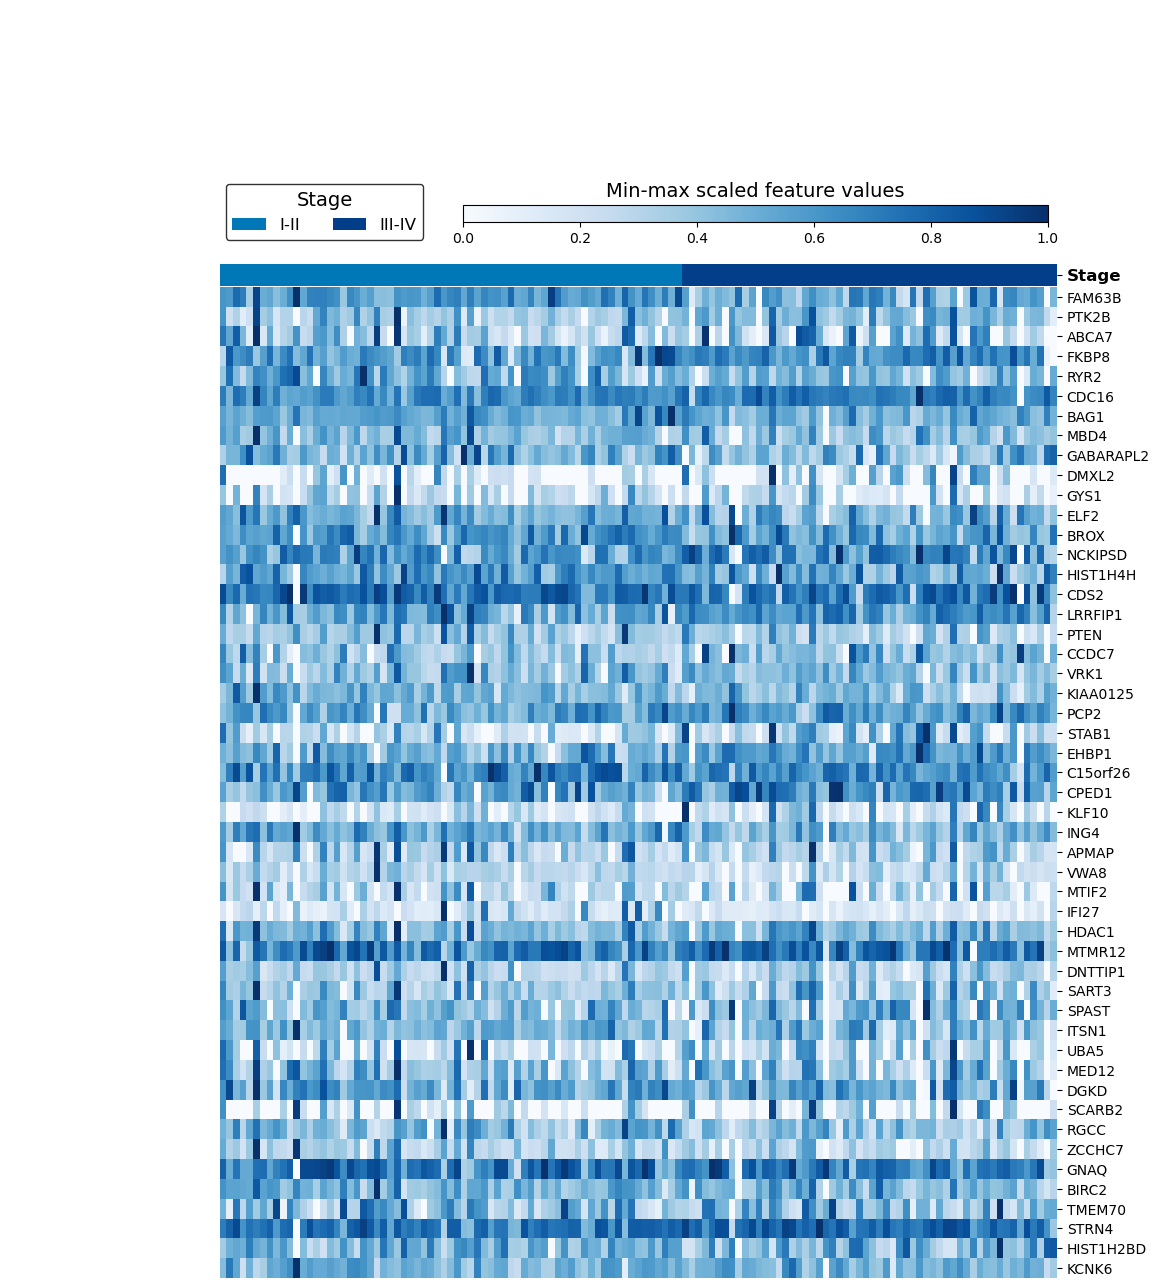

In [11]:
output_path = os.path.join(output_dir, 'heatmap.png')
plot_heatmap(dataset, input_columns, output_path)

In [12]:
def plot_boxplots(predictions, mapping, filename=None):
    preds_vis = predictions.copy(deep=True)

    preds_vis['pred_proba_negative'] = 1 - preds_vis['pred_proba']
    preds_vis = preds_vis.rename(columns={'pred_proba': 'pred_proba_positive'})
    preds_vis['pred_proba'] = preds_vis.apply(lambda x: x['pred_proba_positive'] if x['y_true'] == 1 else x['pred_proba_negative'], axis=1)

    preds_vis_grouped = preds_vis.groupby(by=['id', 'y_true'], as_index=False)['pred_proba'].mean()
    preds_vis_grouped.loc[:, 'y_true'] = preds_vis_grouped['y_true'].map(mapping)
    preds_vis_grouped = preds_vis_grouped.rename(columns={'y_true': 'Stage', 'pred_proba': 'Predicted probability'})
    
    sns.set_style('whitegrid')
    plt.figure(figsize=(11.7, 8.27))
    plt.ylim(0, 1.05)
    
    fig = sns.boxplot(
        data=preds_vis_grouped,
        x='Stage',
        y='Predicted probability',
        orient='v',
        showfliers=False,
        color='#0077b6',
        linewidth=1.5
    )
    for patch in fig.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
        
    fig2 = sns.swarmplot(
        data=preds_vis_grouped,
        x='Stage',
        y='Predicted probability',
        orient='v',
        alpha=1.,
        color='#023e8a'
    )
    fig.set_xlabel('Stage', fontsize=14)
    fig.set_ylabel('Predicted probability', fontsize=14)

    _, xlabels = plt.xticks()
    fig.set_xticklabels(xlabels, size=12)

    _, ylabels = plt.yticks()
    fig.set_yticklabels(ylabels, size=12)
    
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
        
    plt.show()

C:\Users\szyko\AppData\Local\Temp\ipykernel_33884\2217374899.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(xlabels, size=12)
C:\Users\szyko\AppData\Local\Temp\ipykernel_33884\2217374899.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(ylabels, size=12)


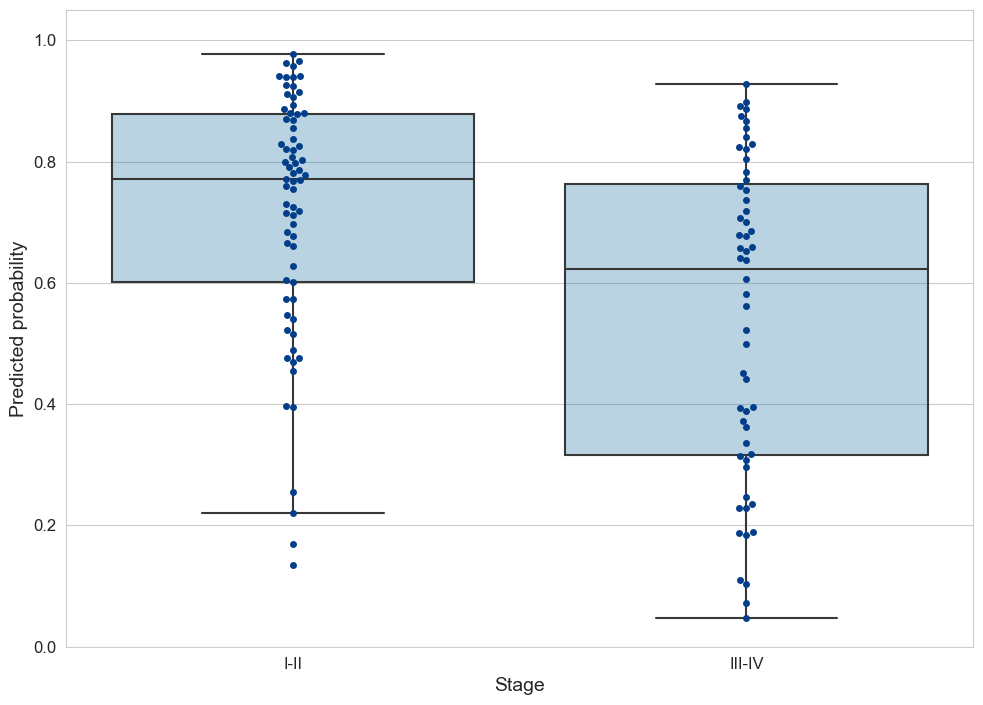

In [13]:
mapping = {0: 'I-II', 1: 'III-IV'}
output_path = os.path.join(output_dir, 'boxplots.png')
plot_boxplots(predictions, mapping, output_path)

In [14]:
def find_nearest(array: np.array, value: float):
    idx = (np.abs(array - value)).argmin()
    return idx


def plot_roc_auc_curve(predictions, selected_thresholds, filename=None):
    fpr, tpr, thresholds = roc_curve(predictions['y_true'], predictions['pred_proba'])
    auc = roc_auc_score(predictions['y_true'], predictions['pred_proba'])

    sns.set_style('whitegrid')
    plt.figure(figsize=(11.7, 8.27))
    plt.plot(fpr, tpr, color='#023e8a', linewidth=2, label=f'XGBClassifier (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], color='#000000', linestyle='dashed', label=f'Random classifier (AUC = 0.5)')
    plt.fill_between(fpr, tpr, color='#0077b6', alpha=0.2)

    selected_indices = np.zeros_like(selected_thresholds, dtype=int)
    for i, thresh in enumerate(selected_thresholds):
        closest_idx = find_nearest(thresholds, thresh)
        selected_indices[i] = closest_idx
        plt.annotate(np.round(thresh, 2), (fpr[closest_idx] + 0.005, tpr[closest_idx] - 0.03), size=12)

    plt.scatter(fpr[selected_indices], tpr[selected_indices], color='#023e8a', linewidth=2, marker='.', s=100, label='Probability thresholds')

    plt.xlabel('False positive rate', fontsize=14)
    plt.ylabel('True positive rate', fontsize=14)
    plt.ylim(0, 1.05)
    plt.xlim(-0.05, 1.)
    plt.legend(loc='lower right', prop={'size': 12})
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()

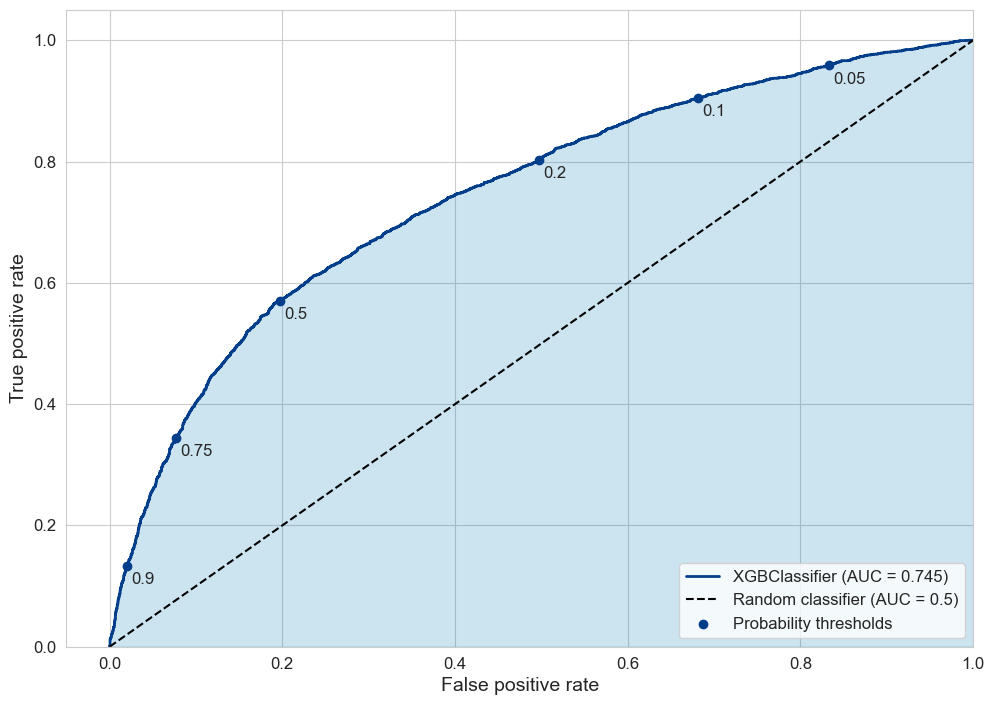

In [15]:
selected_thresholds = [0.05, 0.1, 0.2, 0.5, 0.75, 0.9]

output_path = os.path.join(output_dir, 'roc_auc_curve.png')
plot_roc_auc_curve(predictions, selected_thresholds, output_path)

In [16]:
def plot_confusion_matrix(predictions, labels, filename=None):
    cm = confusion_matrix(predictions['y_true'], predictions['y_pred'], normalize='all')
    cm *= 100

    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    df_annots = df_cm.applymap(lambda x: f'{x:.2f}%')
    fig, ax = plt.subplots(figsize=(11.7, 8.27))
    sns.heatmap(df_cm, annot=df_annots, cmap='Blues', fmt='', linewidths=1, annot_kws={'fontsize': 12},
                cbar_kws={'label': 'Percentage of all tested samples'})
    ax.figure.axes[-1].yaxis.label.set_size(14)
    ax.set_ylabel('True Stage', fontdict={'size': 14})
    ax.set_xlabel('Predicted Stage', fontdict={'size': 14})
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('none')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')

    fig.show()

C:\Users\szyko\AppData\Local\Temp\ipykernel_33884\3923249889.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


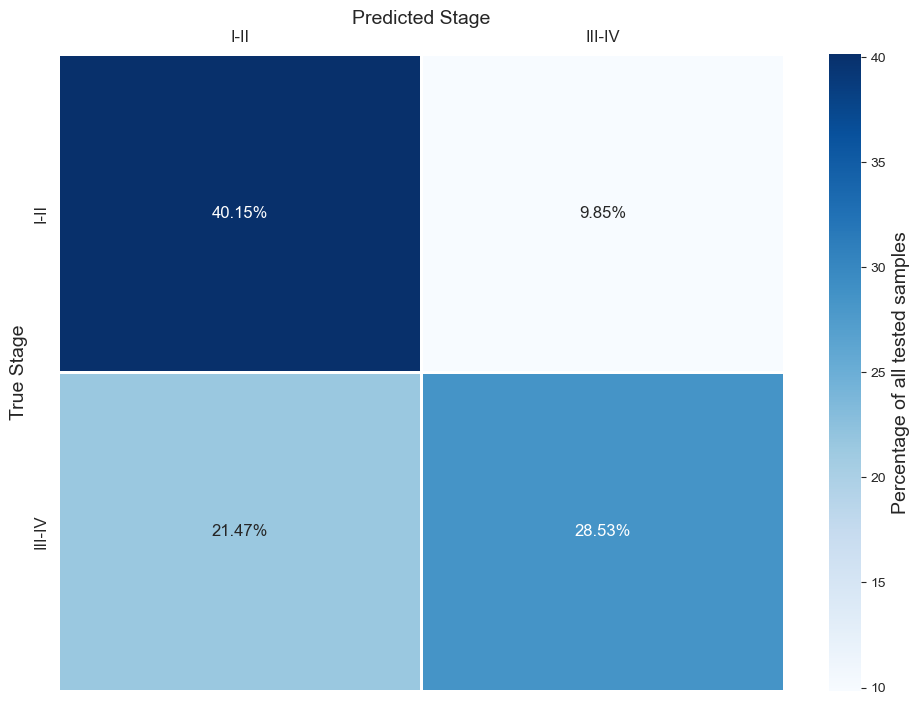

In [17]:
labels = list(mapping.values())

output_path = os.path.join(output_dir, 'confusion_matrix.png')
plot_confusion_matrix(predictions, labels, output_path)